# testing without processor
Only `TTGamma` data, distinguishing prompt photons from fake photons

* Change labels to come from `genPartFlav` instead of dataset

In [1]:
from coffea import hist, util

#import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [3]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

In [4]:
# events from TTGamma
events = NanoEventsFactory.from_root(fileset["TTGamma"][0],
                                     schemaclass=SkimmedSchema,
                                     entry_stop=10000).events()

dataset = "TTGamma"

In [5]:
# photon cuts
photons = events.Photon
photonSelect= ((photons.pt>20) &
               (abs(photons.eta) < 1.4442) &
               (photons.isScEtaEE | photons.isScEtaEB) &
               (photons.electronVeto) & 
               np.invert(photons.pixelSeed)
               )
tightPhotons = photons[photonSelect]

In [6]:
# muon cuts
muons = events.Muon
muonSelectTight = ((muons.pt>30) &
                   (abs(muons.eta)<2.4) &
                   (muons.tightId) &
                   (muons.pfRelIso04_all < 0.15)
                  )
tightMuons = muons[muonSelectTight]

In [7]:
# jet & b-tagged jet cuts
jets = events.Jet

jetSelectTight = ((jets.pt>30) &
                  (abs(jets.eta)<2.4) &
                  (jets.isTight)
                 )
btaggedJetSelect = (jetSelectTight &
                   (jets.btagDeepB>0.6321)
                  )

tightJets = jets[jetSelectTight]
tightBJets = jets[btaggedJetSelect]

In [8]:
# electron cuts
electrons = events.Electron
electronSelectTight = ((electrons.pt> 35) &
                       (abs(electrons.eta)<2.1) &
                       (electrons.cutBased>=4)
                      )
tightEle = electrons[electronSelectTight]

In [9]:
# event cuts
trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24

eventSelection = (trigger &
                  (ak.num(tightMuons)==1) &
                  (ak.num(tightJets)>=4) & 
                  (ak.num(tightBJets)>=1) &
                  (ak.num(tightEle)==0) &
                  (ak.num(tightPhotons)==1))

In [10]:
##### histograms #####

In [11]:
dataset_axis = hist.Cat("dataset","Dataset")

photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
photon_reliso_all_axis = hist.Bin("reliso","photon pfRelIso03_all", 40, -0.5, 6)
photon_reliso_chg_axis = hist.Bin("reliso","photon pfRelIso03_chg", 40, -0.5, 6)
photon_sieie_axis = hist.Bin("sieie","photon sigma I eta I eta", 40, 0, 0.05)
photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
photon_count_axis = hist.Bin("count","Photon number",12,-1,10)

jet_count_axis = hist.Bin("count","Jet number",21,0,20)
jet_pt_axis = hist.Bin("pt","jet $p_T$ [GeV]", 40, 0, 400)
jet_eta_axis = hist.Bin("eta","jet $\eta$", 50, -2.5, 2.5)
jet_phi_axis = hist.Bin("phi","jet $\phi$", 64, -3.2, 3.2)
jet_mass_axis = hist.Bin("mass","jet mass", 40, 0, 10)

muon_pt_axis = hist.Bin("pt","muon $p_T$ [GeV]", 40, 0, 400)
muon_eta_axis = hist.Bin("eta","muon $\eta$", 50, -2.5, 2.5)
muon_phi_axis = hist.Bin("phi","muon $\phi$", 64, -3.2, 3.2)
muon_mass_axis = hist.Bin("mass","muon mass [GeV]", 40, 0, 10)
muon_reliso_all_axis = hist.Bin("reliso","muon_pfRelIso03_all",40, -0.5, 6)
muon_reliso_chg_axis = hist.Bin("reliso","muon_pfRelIso03_chg",40, -0.5, 6)

deltar_axis = hist.Bin("deltar","$\Delta R$", 50, -0.5, 4)

photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",40,-1,15)

In [12]:
photon_pt_hist = hist.Hist("Counts", dataset_axis, photon_pt_axis)
photon_eta_hist = hist.Hist("Counts", dataset_axis, photon_eta_axis)
photon_phi_hist = hist.Hist("Counts", dataset_axis, photon_phi_axis)
photon_reliso_all_hist = hist.Hist("Counts", dataset_axis, photon_reliso_all_axis)
photon_reliso_chg_hist = hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis)
photon_sieie_hist = hist.Hist("Counts", dataset_axis, photon_sieie_axis)
photon_r9_hist = hist.Hist("Counts", dataset_axis, photon_r9_axis)
photon_hoe_hist = hist.Hist("Counts", dataset_axis, photon_hoe_axis)
photon_count_hist = hist.Hist("Counts", dataset_axis, photon_count_axis)

jet_count_hist = hist.Hist("Counts", dataset_axis, jet_count_axis)
jet_pt_hist = hist.Hist("Counts", dataset_axis, jet_pt_axis)
jet_eta_hist = hist.Hist("Counts", dataset_axis, jet_eta_axis)
jet_phi_hist = hist.Hist("Counts", dataset_axis, jet_phi_axis)
jet_mass_hist = hist.Hist("Counts", dataset_axis, jet_mass_axis)

muon_pt_hist = hist.Hist("Counts", dataset_axis, muon_pt_axis)
muon_eta_hist = hist.Hist("Counts", dataset_axis, muon_eta_axis)
muon_phi_hist = hist.Hist("Counts", dataset_axis, muon_phi_axis)
muon_mass_hist = hist.Hist("Counts", dataset_axis, muon_mass_axis)
muon_reliso_all_hist = hist.Hist("Counts", dataset_axis, muon_reliso_all_axis)
muon_reliso_chg_hist = hist.Hist("Counts", dataset_axis, muon_reliso_chg_axis)

deltaR_photon_lepton_hist = hist.Hist("Counts", dataset_axis, deltar_axis)
deltaR_photon_jet_hist = hist.Hist("Counts", dataset_axis, deltar_axis)

photon_genPartFlav_hist = hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis)

In [13]:
photon_pt_hist.fill(dataset=dataset,
                    pt=ak.flatten(tightPhotons[eventSelection].pt))
photon_eta_hist.fill(dataset=dataset,
                     eta=ak.flatten(tightPhotons[eventSelection].eta))
photon_phi_hist.fill(dataset=dataset,
                     phi=ak.flatten(tightPhotons[eventSelection].phi))
photon_reliso_all_hist.fill(dataset=dataset,
                            reliso=ak.flatten(tightPhotons[eventSelection].pfRelIso03_all))
photon_reliso_chg_hist.fill(dataset=dataset,
                            reliso=ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg))
photon_sieie_hist.fill(dataset=dataset,
                       sieie=ak.flatten(tightPhotons[eventSelection].sieie))
photon_r9_hist.fill(dataset=dataset,
                    r9=ak.flatten(tightPhotons[eventSelection].r9))
photon_hoe_hist.fill(dataset=dataset,
                     hoe=ak.flatten(tightPhotons[eventSelection].hoe))
photon_count_hist.fill(dataset=dataset,
                       count=(ak.num(tightPhotons[eventSelection])))

jet_count_hist.fill(dataset=dataset,
                    count=(ak.num(tightJets[eventSelection])))
jet_pt_hist.fill(dataset=dataset,
                 pt=ak.flatten(tightJets[eventSelection].pt))
jet_eta_hist.fill(dataset=dataset,
                  eta=ak.flatten(tightJets[eventSelection].eta))
jet_phi_hist.fill(dataset=dataset,
                  phi=ak.flatten(tightJets[eventSelection].phi))
jet_mass_hist.fill(dataset=dataset,
                   mass=ak.flatten(tightJets[eventSelection].mass))

muon_pt_hist.fill(dataset=dataset,
                  pt=ak.flatten(tightMuons[eventSelection].pt))
muon_eta_hist.fill(dataset=dataset,
                   eta=ak.flatten(tightMuons[eventSelection].eta))
muon_phi_hist.fill(dataset=dataset,
                   phi=ak.flatten(tightMuons[eventSelection].phi))
muon_mass_hist.fill(dataset=dataset,
                    mass=ak.flatten(tightMuons[eventSelection].mass))
muon_reliso_all_hist.fill(dataset=dataset,
                          reliso=ak.flatten(tightMuons[eventSelection].pfRelIso03_all))
muon_reliso_chg_hist.fill(dataset=dataset,
                          reliso=ak.flatten(tightMuons[eventSelection].pfRelIso03_chg))

deltaR_photon_lepton_hist.fill(dataset=dataset,
                               deltar=ak.flatten(tightPhotons[eventSelection,:1].delta_r(tightMuons[eventSelection,:1])))
deltaR_photon_jet_hist.fill(dataset=dataset,
                            deltar=ak.flatten(tightPhotons[eventSelection,:1].delta_r(tightJets[eventSelection,:1])))

photon_genPartFlav_hist.fill(dataset=dataset,
                             flav=ak.flatten(tightPhotons[eventSelection].genPartFlav))

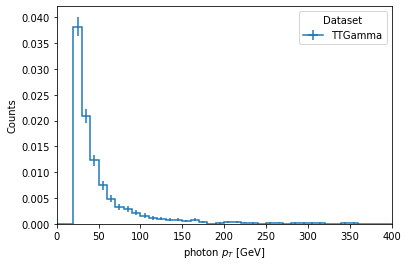

In [14]:
hist.plot1d(photon_pt_hist,overlay='dataset',stack=False,density=True)
plt.show()

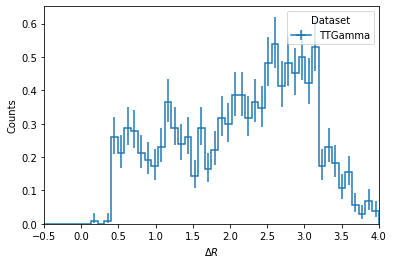

In [15]:
hist.plot1d(deltaR_photon_lepton_hist,overlay='dataset',stack=False,density=True)
plt.show()

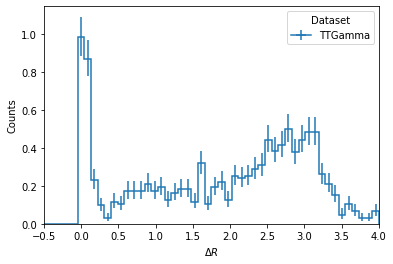

In [16]:
hist.plot1d(deltaR_photon_jet_hist,overlay='dataset',stack=False,density=True)
plt.show()

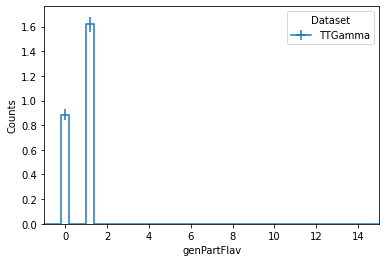

In [17]:
hist.plot1d(photon_genPartFlav_hist,overlay='dataset',stack=False,density=True)
plt.show()

In [18]:
###### column accumulators #######

In [19]:
photon_pt = ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection],8,clip=True))
photon_eta = ak.to_numpy(ak.pad_none(tightPhotons.eta[eventSelection],8,clip=True))
photon_phi = ak.to_numpy(ak.pad_none(tightPhotons.phi[eventSelection],8,clip=True))
photon_pfRelIso03_all = ak.to_numpy(ak.pad_none(tightPhotons.pfRelIso03_all[eventSelection],8,clip=True))
photon_pfRelIso03_chg = ak.to_numpy(ak.pad_none(tightPhotons.pfRelIso03_chg[eventSelection],8,clip=True))
photon_sieie = ak.to_numpy(ak.pad_none(tightPhotons.sieie[eventSelection],8,clip=True))
photon_r9 = ak.to_numpy(ak.pad_none(tightPhotons.r9[eventSelection],8,clip=True))
photon_hoe = ak.to_numpy(ak.pad_none(tightPhotons.hoe[eventSelection],8,clip=True))
photon_count = ak.to_numpy(ak.num(tightPhotons[eventSelection]))
photon_genPartFlav = ak.to_numpy(ak.pad_none(tightPhotons.genPartFlav[eventSelection],8,clip=True))

###
jet_count = ak.to_numpy(ak.num(tightJets[eventSelection]))
jet_pt = ak.to_numpy(ak.pad_none(tightJets.pt[eventSelection],8,clip=True))
jet_eta = ak.to_numpy(ak.pad_none(tightJets.eta[eventSelection],8,clip=True))
jet_phi = ak.to_numpy(ak.pad_none(tightJets.phi[eventSelection],8,clip=True))
jet_mass = ak.to_numpy(ak.pad_none(tightJets.mass[eventSelection],8,clip=True))

###
muon_pt = ak.to_numpy(ak.pad_none(tightMuons.pt[eventSelection],8,clip=True))
muon_eta = ak.to_numpy(ak.pad_none(tightMuons.eta[eventSelection],8,clip=True))
muon_phi = ak.to_numpy(ak.pad_none(tightMuons.phi[eventSelection],8,clip=True))
muon_mass = ak.to_numpy(ak.pad_none(tightMuons.mass[eventSelection],8,clip=True))
muon_pfRelIso03_all = ak.to_numpy(ak.pad_none(tightMuons.pfRelIso03_all[eventSelection],8,clip=True))
muon_pfRelIso03_chg = ak.to_numpy(ak.pad_none(tightMuons.pfRelIso03_chg[eventSelection],8,clip=True))

###
deltaR_photon_lepton = ak.to_numpy(ak.pad_none(tightPhotons[eventSelection,:1].delta_r(tightMuons[eventSelection,:1]),1,clip=True))
deltaR_photon_jet = ak.to_numpy(ak.pad_none(tightPhotons[eventSelection,:1].delta_r(tightJets[eventSelection,:1]),1,clip=True))


In [20]:
photon_count.shape

(1157,)

In [21]:
photon_pt.shape

(1157, 8)

In [22]:
np.array(photon_pt)[:,0]

array([25.824781, 35.281075, 34.028465, ..., 20.967505, 41.821255,
       26.404654], dtype=float32)

In [23]:
np.array(photon_pt)[:,0].shape

(1157,)

In [24]:
####### processing for machine learning #######

In [25]:
df = pd.DataFrame({
    'photon_pt': np.array(photon_pt)[:,0],
    'photon_eta': np.array(photon_eta)[:,0],
    'photon_phi': np.array(photon_phi)[:,0],
    'photon_hoe': np.array(photon_hoe)[:,0],
    'photon_r9': np.array(photon_r9)[:,0],
    'photon_sieie': np.array(photon_sieie)[:,0],
    'photon_pfRelIso03_all': np.array(photon_pfRelIso03_all)[:,0],
    'photon_pfRelIso03_chg': np.array(photon_pfRelIso03_chg)[:,0],
    'photon_count': np.array(photon_count),
    'photon_genPartFlav': np.array(photon_genPartFlav)[:,0],  ## target ##
    
    'jet_count': np.array(jet_count),
    'jet_pt': np.array(jet_pt)[:,0],
    'jet_eta': np.array(jet_eta)[:,0],
    'jet_phi': np.array(jet_phi)[:,0],
    'jet_mass': np.array(jet_mass)[:,0],
    
    'muon_pt': np.array(muon_pt)[:,0],
    'muon_eta': np.array(muon_eta)[:,0],
    'muon_phi': np.array(muon_phi)[:,0],
    'muon_mass': np.array(muon_mass)[:,0],
    'muon_pfRelIso03_all': np.array(muon_pfRelIso03_all)[:,0],
    'muon_pfRelIso03_chg': np.array(muon_pfRelIso03_chg)[:,0],
    
    'deltaR_photon_lepton': np.array(deltaR_photon_lepton)[:,0],
    'deltaR_photon_jet': np.array(deltaR_photon_jet)[:,0],
    
    #'target': np.array(outputMC['label'].value)[:,0]
})
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,photon_count,photon_genPartFlav,...,jet_phi,jet_mass,muon_pt,muon_eta,muon_phi,muon_mass,muon_pfRelIso03_all,muon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
count,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.0,1157.000000,...,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000
mean,49.074131,0.035144,0.042858,0.102568,0.799614,0.011013,0.500894,0.309495,1.0,0.647364,...,0.011096,16.166845,70.528236,-0.002633,-0.007489,0.105713,0.017186,0.008397,2.149714,1.841543
std,41.622272,0.762631,1.845154,0.147042,0.198861,0.003369,0.924297,0.614703,0.0,0.477997,...,1.802328,10.792919,44.933998,1.042010,1.815960,0.000000,0.025136,0.015342,0.891409,1.174477
min,20.004259,-1.433350,-3.138672,0.000000,0.192383,0.005318,0.000000,0.000000,1.0,0.000000,...,-3.133789,3.306641,30.008116,-2.375977,-3.137695,0.105713,0.000000,0.000000,0.183863,0.001652
25%,25.472223,-0.587280,-1.560059,0.000000,0.666992,0.008995,0.009612,0.000000,1.0,0.000000,...,-1.505371,10.328125,41.400139,-0.753540,-1.560059,0.105713,0.000000,0.000000,1.394264,0.763312
50%,35.071461,0.076050,0.093887,0.019287,0.890625,0.009468,0.146177,0.073107,1.0,1.000000,...,0.034271,13.734375,57.147926,-0.044319,-0.093048,0.105713,0.006732,0.000000,2.300767,2.123579
75%,54.655857,0.640381,1.612793,0.186523,0.958984,0.012245,0.750167,0.427222,1.0,1.000000,...,1.551514,19.078125,84.590981,0.782227,1.567627,0.105713,0.024832,0.011055,2.866857,2.833286
max,426.615692,1.441895,3.138672,1.390625,1.078125,0.024841,16.187374,11.755681,1.0,1.000000,...,3.138672,174.250000,636.924561,2.384766,3.137695,0.105713,0.160318,0.115287,4.260221,4.175145


In [26]:
# split into features and labels
X = np.array(df.drop(['photon_genPartFlav'],axis=1))
y = df['photon_genPartFlav']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(y_train.max())
print(y_train.min())

(693, 22)
1
0


In [27]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [28]:
model = Sequential()
model.add(Dense(32, input_shape=(22,), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                736       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train_scaled, y_train, epochs=20, batch_size=128)

Epoch 1/20
6/6 [==============================] - 0s 1ms/step - loss: 0.7577 - accuracy: 0.4257
Epoch 2/20
6/6 [==============================] - 0s 1ms/step - loss: 0.6830 - accuracy: 0.5354
Epoch 3/20
6/6 [==============================] - 0s 1ms/step - loss: 0.6203 - accuracy: 0.6537
Epoch 4/20
6/6 [==============================] - 0s 1ms/step - loss: 0.5669 - accuracy: 0.7734
Epoch 5/20
6/6 [==============================] - 0s 1ms/step - loss: 0.5199 - accuracy: 0.8326
Epoch 6/20
6/6 [==============================] - 0s 1ms/step - loss: 0.4776 - accuracy: 0.8644
Epoch 7/20
6/6 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.8773
Epoch 8/20
6/6 [==============================] - 0s 1ms/step - loss: 0.4026 - accuracy: 0.8860
Epoch 9/20
6/6 [==============================] - 0s 1ms/step - loss: 0.3693 - accuracy: 0.8918
Epoch 10/20
6/6 [==============================] - 0s 1ms/step - loss: 0.3394 - accuracy: 0.8903
Epoch 11/20
6/6 [======================

In [30]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.27756
Test accuracy: 0.875


In [31]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

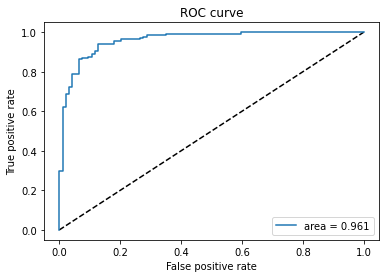

In [32]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [33]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

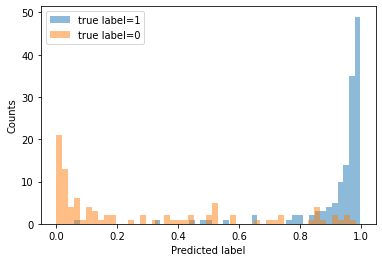

In [34]:
plt.hist(predTrue,bins=50,alpha=0.5,label='true label=1')
plt.hist(predFalse,bins=50,alpha=0.5,label='true label=0')

plt.xlabel('Predicted label')
plt.ylabel('Counts')
plt.title('')
plt.legend(loc='best')
plt.show()